__This book shows alternative prediction models of integrating DMS and AS data.__

In [1]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np
sys.path.append("../src/")
import preproc as preproc
import train as train
import tune as tune
import analysis as ana

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
# Same as Firnberg et al., 2014
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Protein property features (alanine scanning feature is not included).
DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']

In [3]:
def preproc_demask_dmsas_data(input_data):
    """Impute, encode and weight DMS+AS data.
    """
    preproc_data = input_data.copy()
    preproc_data = preproc.impute_missing_value(preproc_data, None, ['AS_score'])
    # Encode wild-type & variant type amino acid with AS scores.
    preproc_data, encoded_col = preproc.encode_categorical_feature(preproc_data, ['aa1', 'aa2'], ['aa1', 'aa2'])
    preproc_data[encoded_col] = preproc_data[encoded_col].mul(preproc_data['AS_score'], axis='index')
    # Weight each variant.
    preproc_data = train.add_training_weight(preproc_data)
    return preproc_data, encoded_col


def model_linear_predictor_lopo(input_data, output_dir, encoded_col):
    """Run leave-one-protein-out cross-validation on (filtered) DMS/AS data.
    """
    # LOPO CV
    for unip in input_data['uniprot_id'].unique():
        train_data = input_data.query("uniprot_id != @unip")
        test_data_ori = input_data.query("uniprot_id == @unip")
        train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)

        for model in ['with_as', 'no_as']:
            output_header = f"{output_dir}{unip}_{model}_"
            if model == 'with_as':
                model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
            else:
                model_features = DEMASK_FEATURES.copy()

            estimator = LinearRegression(n_jobs=1)
            predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
            test_data = test_data_ori.copy()
            test_data['pred_score'] = predictor.predict(test_data[model_features])
            test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
    return


def read_lopo_prediction_result(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_as', 'no_as']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0) 
                                    for unip in target_proteins])
    pred_merge = pd.merge(results['with_as'], results['no_as'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge

# Read data

DMS and AS data were normalised as mentioned in the Method that:
* Contain only single amino acid (alanine) substitution compared to the reference protein sequence
* score to 1 for wildtype-like variants
* score to 0 for nonsense-like variants

The `dataset_info` file contains the experimental information of DMS and AS data.

In [4]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/dms_DeMaSk_features_221024.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/as_data_221024.csv')

data_info = pd.read_csv('../data/data_info/dms_as_info_221024.csv', index_col=0)

In [5]:
all_as = norm_as.copy()
# Merge in a cartesian product way.
dms_all_as = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()

dms_all_as, encoded_col = preproc_demask_dmsas_data(dms_all_as)

# Compare with published

To verify our re-implemented DeMaSk method, we compared the prediction result either using the published or our own (re-implemented) code & data.

We present the modelling & evaluation process for using our own code and data in the following cells.

Modelling with the published code and/or data were finished elsewhere and directly read in this notebook. __Code and results are available upon request.__

LOPO CV on all DMS collected with no AS data (`Our data & code`).

In [5]:
comp_model = dict()

In [6]:
# Weight each mutatnt.
work_data = train.add_training_weight(norm_dms)

# Leave-one-protein-out cross-validation
test_perf = dict()
for unip in work_data['uniprot_id'].unique():  
    # Train.
    train_data = work_data.query("uniprot_id != @unip")
    test_data = work_data.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]
comp_model['Our data & code'] = test_perf

Collect results run by DeMaSk code. Code and results are not provided but available upon request.

In [6]:
#root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
exp_id = {'DeMaSk data & code': 'demask_web_221024', 'Our data & DeMaSk code': 'own_data_221024'}

for exp_name in ['DeMaSk data & code', 'Our data & DeMaSk code']:
    files = os.listdir(f"{root}/result/{exp_id[exp_name]}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_id[exp_name]}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_id[exp_name]}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Remove nonsense variants.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

Prediction performance on each DMS dataset for modelling with published DeMaSk or our own code & data, creating __Figure S3__.

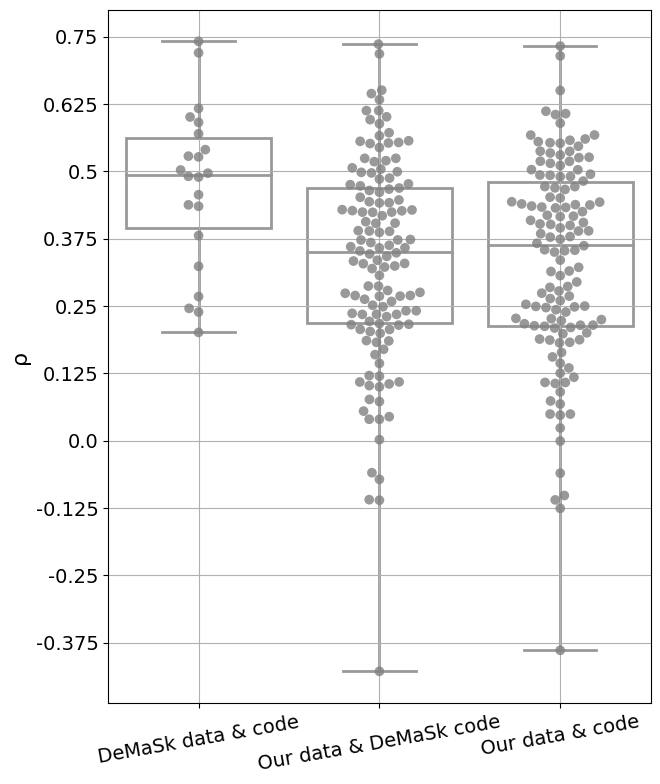

In [8]:
vis_data = pd.DataFrame(comp_model)

fig, ax = plt.subplots(1,1,figsize=(7,9), sharey=True)
fig.patch.set_facecolor('w')
order = ['DeMaSk data & code', 'Our data & DeMaSk code', 'Our data & code']
sns.swarmplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=7, alpha=0.8, zorder=2)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2, zorder=1)
ax.set_yticks(np.arange(-0.375,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=14)
ax.grid()
plt.show()

# Envision-based predictor

[Envision (Gray et al., 2018)](https://www.cell.com/cell-systems/fulltext/S2405-4712(17)30492-1) is one of the first DMS-based variant impact predictors. In this section, we managed to also improve Envision by incorporating AS data.

The data processing, modelling and evaluation follows a similar pipeline as the DeMaSk-based analysis.

## Data preparation

Missing feature values were imputed by the mean values for numerical features or the most frequent values for categorical features. Categorical features are encoded with the one-hot encoder. 

DMS and AS data pairs with high assay compatibility were used for modelling, with missing AS scores imputed by mean.

In [10]:
# Preprocess data: impute missing values and encode categorical features.
norm_dms_env = pd.read_csv('../data/normalized/dms_Envision_features_221024.csv', 
                           index_col=0, na_values=[''], keep_default_na=False)

# All Envision features.
features = ['aa1', 'aa2', 'aa1_polarity', 'aa2_polarity', 'aa1_PI','aa2_PI', 'deltaPI', 
            'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight', 'aa1vol', 'aa2vol', 'deltavolume',
            'aa1_psic', 'aa2_psic', 'delta_psic', 'accessibility', 'dssp_sec_str', 'phi_psi_reg',
            'delta_solvent_accessibility', 'b_factor', 'mut_msa_congruency', 'seq_ind_closest_mut', 
            'mut_mut_msa_congruency', 'evolutionary_coupling_avg']
categ_feat = ['aa1', 'aa2', 'aa1_polarity', 'aa2_polarity', 'dssp_sec_str', 'phi_psi_reg']
numer_feat = [x for x in features if x not in categ_feat]

norm_dms_env = preproc.impute_missing_value(norm_dms_env, categ_feat, numer_feat)
norm_dms_env, encoded_col = preproc.encode_categorical_feature(norm_dms_env, categ_feat, ['aa1', 'aa2'])
envision_features = encoded_col + numer_feat

In [11]:
# Pick AS subset that are highly compatibility with given DMS assay.

comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

# Merge AS data and DMS data with Envision feature.
dmsas_env = pd.merge(norm_dms_env, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_env['dmsa_id'] = dmsas_env['dms_id'] + '@' + dmsas_env['Ascan_id'].astype(str)
dmsas_env['Ascan_score_avail'] = ~dmsas_env['AS_score'].isna()
dmsas_env = preproc.impute_missing_value(dmsas_env, None, ['AS_score'])
dmsas_env = train.add_training_weight(dmsas_env)

## Modelling

### Envision-based model

The following code run the leave-one-protein-out cross-validation on DMS+AS data.
1. Data from each protein target in the DMS+AS data are picked as testing data.
2. The rest data were used for training.
3. Instead of Envision features, Extra AS scores and AS score availability (`Ascan_score_avail`) features were used to test if AS data can improve Envision model. 
4. Before the training process, we tune the hyper-parameters of the GradientBoostingRegressor by Bayesian optimisation with GroupKFold method (Group:protein ID, `K=30`) using training data.
4. Predictor using or not using AS data (together with the available feature) are trained separately and taken for prediction.

The demonstration and real tuning parameters are shown below. The later one was __run on a high-performance computer__ that was supported by The University of Melbourne’s Research Computing Services and the Petascale Campus Initiative. The model results are __copied__ to the corresponding folder.

__Set tuning parameters:__

In [11]:
# These are demonstration parameters which are much faster to run.

seed = 0
output_dir = '../result/prediction/alternative_models/envision/trial/'
# Hyper-parameter space to be optimized by tuning.
search_space = [{'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(1, 3), 'dtype': int},
                {'name': 'max_depth', 'type': 'discrete', 'domain': np.arange(1, 3), 'dtype': int}]
# Set arguments used by Bayesian Optimization model.
bo_kwargs = {'num_iterations': 1, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 1000}
# Set arguments for cross-validation tuning.
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(2), 'n_jobs': 4}

In [ ]:
"""
# These are the real parameters.
seed = 0
output_dir = '../result/prediction/alternative_models/envision/full_envision/'
search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 61), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 72000}
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}
"""

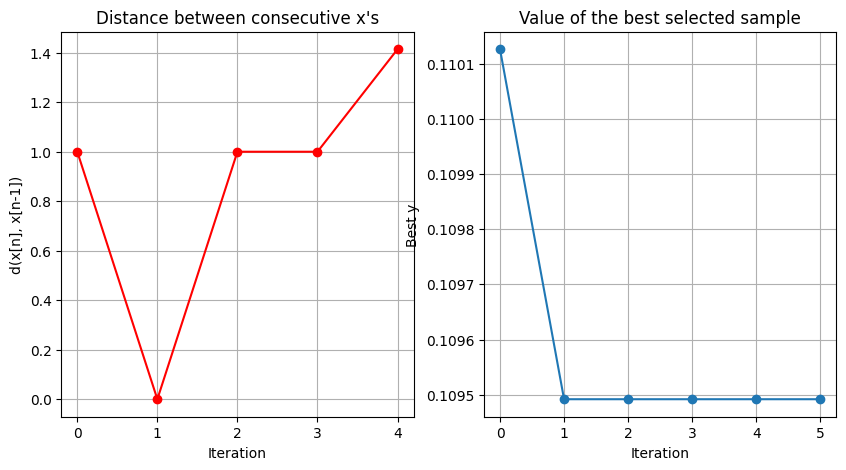

In [12]:
# Leave-one-protein-out cross-validation
for unip in dmsas_env['uniprot_id'].unique():
    train_data = dmsas_env.query("uniprot_id != @unip")
    test_data_ori = dmsas_env.query("uniprot_id == @unip")
    cv_kwargs['fit_params'] = {'sample_weight': train_data['weight']}
    cv_kwargs['groups'] = train_data['uniprot_id']
    
    for model in ['with_as', 'no_as']:
        if model == 'with_as':
            # Extra feature of Ascan_score_avail indicates the availability of AS data.
            model_features = envision_features + ['AS_score']  
        else:
            model_features = envision_features.copy()
        output_header = f"{output_dir}{unip}_{model}_"
        bo_kwargs['output_header'] = output_header

        # Training & testing.
        estimator = GradientBoostingRegressor(random_state=seed)
        predictor = tune.fit_best_estimator(search_space, estimator, train_data[model_features], 
                                            train_data['score'], cv_kwargs, bo_kwargs)
        test_data = test_data_ori.copy()
        test_data['pred_score'] = predictor.predict(test_data[model_features])
        
        # Saving results.
        test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
        tune.save_feature_importance(predictor, output_header)
        tune.save_tuned_hyperparameters(predictor, search_space, output_header)
        break
    break

### Comparison DeMaSk-based result

As mentioned, Envision feature are not available (provided online) for some proteins whose data wre removed from the above analysis.

So, for comparison, we repeated the DeMaSk-based analysis on the same subset of data.

In [13]:
# Build DeMaSk-based predictor on the same subset of data (some proteins have no Envision features available).

prot_with_envf = norm_dms_env.uniprot_id.unique()  # Proteins with Envision feature.
overlap_data = norm_dms.query("uniprot_id in @prot_with_envf")

comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

dmsas_dem = pd.merge(overlap_data, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_dem['dmsa_id'] = dmsas_dem['dms_id'] + '@' + dmsas_dem['Ascan_id'].astype(str)
dmsas_dem['Ascan_score_avail'] = ~dmsas_dem['AS_score'].isna()
dmsas_dem, encoded_col = preproc_demask_dmsas_data(dmsas_dem)

In [14]:
output_dir = '../result/prediction/alternative_models/envision/demask_comparison/'
# Leave-one-protein-out cross-validation
for unip in dmsas_dem['uniprot_id'].unique():
    train_data = dmsas_dem.query("uniprot_id != @unip")
    test_data_ori = dmsas_dem.query("uniprot_id == @unip")
    train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)

    for model in ['with_as', 'no_as']:
        output_header = f"{output_dir}{unip}_{model}_"
        if model == 'with_as':
            model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
        else:
            model_features = DEMASK_FEATURES.copy()

        estimator = LinearRegression(n_jobs=1)
        predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
        test_data = test_data_ori.copy()
        test_data['pred_score'] = predictor.predict(test_data[model_features])
        test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

While reading the prediction result:
1. We collected the result predicted by either Envision-based or DeMaSk-based predictor.
2. The prediction result using AS data or not (control) were merged together for comparison.

In [12]:
candidate_unip = dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique()
env_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/full_envision/', 
                                             candidate_unip)
dem_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/demask_comparison/',
                                             candidate_unip)

While evaluating the prediction performance:
1. We evaluate the performance by calculating the Spearman's ρ between the experimental score (`score`) and prediction result (`pred_score_ala` or `pred_score_noala`).
2. This calculation was done for each pair of DMS/AS data, identified by `dmsa_id`.
3. Performance change is calculated from the correlation change for prediction result using AS data or not.

In [13]:
# Evaluate performance with Spearman's ρ on each DMS/AS pair.
env_model_perform = []
for model, pred_result in {'Envision-based ± AS': env_based_pred, 'DeMaSk-based ± AS': dem_based_pred}.items():
    perf_with_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    env_model_perform.append(perf_merge)
env_model_perform = pd.concat(env_model_perform)

# Post process.
env_model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
env_model_perform['diff_spear'] = env_model_perform['With AS'] - env_model_perform['No AS']
env_model_perform = pd.merge(env_model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

In [14]:
if_one_residue = dmsas_env.groupby('dmsa_id')['u_pos'].nunique()
env_one_residue_filter = if_one_residue[if_one_residue == 1].index

The following code show the prediction performance while using AS data or not, for either Envision-based or DeMaSk-based result, creating __Figure S6__.

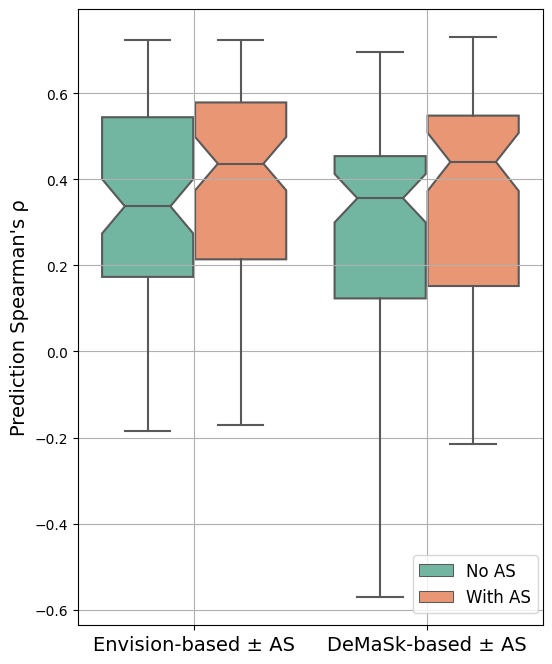

In [15]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = env_model_perform[env_model_perform['Ascan_id'].notna()].query("dmsa_id not in @env_one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model', 'size'], value_vars=['No AS', 'With AS'], value_name='spear', 
                         var_name='Feature')

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.72,0.02], fontsize=12)
ax.grid()
plt.show()

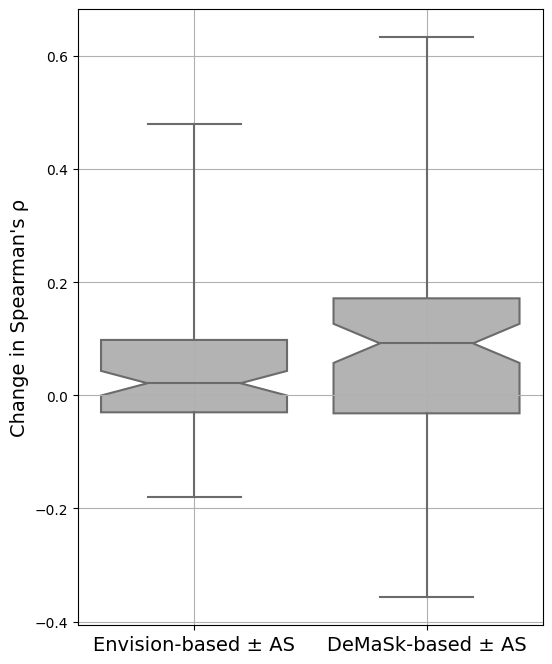

In [16]:
vis_data = env_model_perform[env_model_perform['Ascan_id'].notna()].query("dmsa_id not in @env_one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

# Statstical testing

Here we used statistical testings to indicate if the imporvement of prediction performance is significant or not. This anlysis is realted to __Fig 5, S4, S5 & S6__.

To do this:
1. We evaluated and merged the model performance for predicting with _All AS data, Compatibility filtered, Correlation matched, High+medium compatibility, Envision based predictor and DeMaSk based predictor on data with Envision feature_.
2. We computed the p-values between result using AS data or not, using paired t-test.
3. We computed the p-values between results filter/matched in different ways, using Welch's t-test.
4. All the raw p-values are corrected Holm–Šidák method jointly.

In [9]:
# These codes are identical as Part 2.

file_dir = {'All AS data': '../result/prediction/linear_as/all_as/',
            'Compatibility filtered': '../result/prediction/linear_as/compatible_as/',
            'Correlation matched': '../result/prediction/linear_as/correlate_as/',
            'High+medium\ncompatibility': '../result/prediction/linear_as/high+med_as/'}
target_proteins = norm_dms['uniprot_id'].unique()

# Read prediction results.
ttest_mut_prediction = dict()
for model in file_dir.keys():
    pred_merge = read_lopo_prediction_result(file_dir[model], target_proteins)
    ttest_mut_prediction[model] = pred_merge
    
# Evaluate performance with Spearman's ρ on each DMS/AS pair.
ttest_model_perform = []
for model in ttest_mut_prediction.keys():
    perf_with_as = ana.subgroup_spearmanr(ttest_mut_prediction[model], 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(ttest_mut_prediction[model], 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    ttest_model_perform.append(perf_merge)
ttest_model_perform = pd.concat(ttest_model_perform)

# Post process.
ttest_model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
ttest_model_perform['diff_spear'] = ttest_model_perform['With AS'] - ttest_model_perform['No AS']
ttest_model_perform = pd.merge(ttest_model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

if_one_residue = dms_all_as.groupby('dmsa_id')['u_pos'].nunique()
one_residue_filter = if_one_residue[if_one_residue == 1].index

# Combine performance evaluation results and remove data that no or only one one residue has (filtered) AS score.
foo = ttest_model_perform[~ttest_model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
bar = env_model_perform[env_model_perform['Ascan_id'].notna()].query("dmsa_id not in @env_one_residue_filter")
work_data = pd.concat([foo, bar], ignore_index=True)

In [25]:
raw_p = dict()

# Do paired t-test showing if extra AS data improves prediction performance. Related to Fig S4 & S6.
for model, data in vis_data.groupby('model'):
    if model == 'High+medium\ncompatibility':  # This compairson was not discussed in the paper.
        continue
    raw_p[model] = ttest_rel(data['With AS'], data['No AS'], alternative='greater')[1]
    
# Do Welch's test showing if the filtering/matching methods have different mean improvement. Related to Fig 5 & S5.
improve_data = dict()
for model, data in vis_data.groupby('model'):
    improve_data[model] = data['diff_spear']
# Pairs to be compared.
pairs = [['All AS data', 'Compatibility filtered'],
         ['All AS data', 'Correlation matched'],
         ['Compatibility filtered', 'Correlation matched'],
         ['All AS data', 'High+medium\ncompatibility'],
         ['Compatibility filtered', 'High+medium\ncompatibility']]
for pair in pairs:
    raw_p[f"{pair[0]};{pair[1]}"] = ttest_ind(data_dict[pair[0]], data_dict[pair[1]], equal_var=False)[1]
raw_p = pd.Series(raw_p)
multitest = multipletests(list(raw_p.values), method='hs')
test_result = pd.DataFrame(data=[raw_p.index, multitest[0], multitest[1]], 
                           index=['Compmarison', 'If significant', 'Corrected p-values']).T
test_result

,Compmarison,If significant,Corrected p-values
0,All AS data,True,0.00177
1,Compatibility filtered,True,0.001277
2,Correlation matched,False,0.192028
3,DeMaSk-based ± AS,True,0.00066
4,Envision-based ± AS,True,0.013694
5,All AS data;Compatibility filtered,True,0.040369
6,All AS data;Correlation matched,False,0.680734
7,Compatibility filtered;Correlation matched,False,0.461705
8,All AS data;High+medium\ncompatibility,False,0.974303
9,Compatibility filtered;High+medium\ncompatibility,False,0.051315


# Modelling only with AS-available residues

In the previous process, we included variants without available AS data for modelling. Here we tried to remove these variants, by only using variant with available (filtered/matched) AS data for training and evaluation. This result is related to __Fig S11__.

All modelling as well as evaluation are the same as the main result, except that variants without available (filtered/matched) AS data are removed.

In [26]:
def model_linear_predictor_lopo_sparse(input_data, output_dir, encoded_col):
    """
    Run leave-one-protein-out cross-validation on (filtered) DMS/AS data.
    This is specially designed when input data is small that matrix score can be missing.
    """
    # LOPO CV
    for unip in input_data['uniprot_id'].unique():
        train_data = input_data.query("uniprot_id != @unip")
        test_data_ori = input_data.query("uniprot_id == @unip")
        train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)
        test_data_ori['matrix'] = test_data_ori['matrix'].fillna(test_data_ori['matrix'].mean())

        for model in ['with_as', 'no_as']:
            output_header = f"{output_dir}{unip}_{model}_"
            if model == 'with_as':
                model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
            else:
                model_features = DEMASK_FEATURES.copy()

            estimator = LinearRegression(n_jobs=1)
            predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
            test_data = test_data_ori.copy()
            test_data['pred_score'] = predictor.predict(test_data[model_features])
            test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
    return

In [29]:
all_as = norm_as.copy()
# Merge in a cartesian product way.
dms_all_as_avai = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                           on=['uniprot_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_all_as_avai['dmsa_id'] = dms_all_as_avai['dms_id'] + '@' + dms_all_as_avai['Ascan_id'].astype(str)
dms_all_as_avai['Ascan_score_avail'] = ~dms_all_as_avai['AS_score'].isna()

dms_all_as_avai, encoded_col = preproc_demask_dmsas_data(dms_all_as_avai)
dms_all_as_avai = dms_all_as_avai[dms_all_as_avai['Ascan_score_avail']]  # The only difference.

model_linear_predictor_lopo_sparse(dms_all_as_avai, 
                                   '../result/prediction/alternative_models/model_available/all_as/', 
                                   encoded_col)

In [31]:
# Pick AS subset that are highly compatibility with given DMS assay.

# And matching DMS IDs.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_comp_as_avai = pd.merge(norm_dms, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_comp_as_avai['dmsa_id'] = dms_comp_as_avai['dms_id'] + '@' + dms_comp_as_avai['Ascan_id'].astype(str)
dms_comp_as_avai['Ascan_score_avail'] = ~dms_comp_as_avai['AS_score'].isna()

dms_comp_as_avai, encoded_col = preproc_demask_dmsas_data(dms_comp_as_avai)
dms_comp_as_avai = dms_comp_as_avai[dms_comp_as_avai['Ascan_score_avail']]  # The only difference.

model_linear_predictor_lopo_sparse(dms_comp_as_avai, 
                                   '../result/prediction/alternative_models/model_available/compatible_as/', 
                                   encoded_col)

In [32]:
# Pick AS data with highest regularized correlation for DMS study.

corr_as_id = []
for index, df in data_info.groupby('dms_id', as_index=False):
    df = df.sort_values(['regularized_correlation', 'n_ala', 'Ascan_id'])
    if len(df) > 0:
        corr_as_id.append(df.iloc[-1][['dms_id', 'Ascan_id']])  # Pick data with largest regularized correlation.
# And matching DMS IDs.
corr_as_id = pd.DataFrame(corr_as_id)
corr_as = pd.merge(norm_as, corr_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_corr_as_avai = pd.merge(norm_dms, corr_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_corr_as_avai['dmsa_id'] = dms_corr_as_avai['dms_id'] + '@' + dms_corr_as_avai['Ascan_id'].astype(str)
dms_corr_as_avai['Ascan_score_avail'] = ~dms_corr_as_avai['AS_score'].isna()

dms_corr_as_avai, encoded_col = preproc_demask_dmsas_data(dms_corr_as_avai)
dms_corr_as_avai = dms_corr_as_avai[dms_corr_as_avai['Ascan_score_avail']]  # The only difference.

model_linear_predictor_lopo_sparse(dms_corr_as_avai, 
                                   '../result/prediction/alternative_models/model_available/correlate_as/', 
                                   encoded_col)

In [33]:
file_dir = {'All AS data': '../result/prediction/alternative_models/model_available/all_as/',
            'Compatibility filtered': '../result/prediction/alternative_models/model_available/compatible_as/',
            'Correlation matched': '../result/prediction/alternative_models/model_available/correlate_as/'}
target_proteins = [dms_all_as_avai['uniprot_id'].unique(),
                   dms_comp_as_avai['uniprot_id'].unique(),
                   dms_corr_as_avai['uniprot_id'].unique()]

# Read prediction results.
mut_prediction_avail = dict()
i = 0
for model in file_dir.keys():
    pred_merge = read_lopo_prediction_result(file_dir[model], target_proteins[i])
    mut_prediction_avail[model] = pred_merge
    i += 1
    
# Evaluate performance with Spearman's ρ on each DMS/AS pair.
model_perform_avail = []
for model in mut_prediction_avail.keys():
    perf_with_as = ana.subgroup_spearmanr(mut_prediction_avail[model], 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(mut_prediction_avail[model], 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    model_perform_avail.append(perf_merge)
model_perform_avail = pd.concat(model_perform_avail)

# Post process.
model_perform_avail.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
model_perform_avail['diff_spear'] = model_perform_avail['With AS'] - model_perform_avail['No AS']
model_perform_avail = pd.merge(model_perform_avail, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

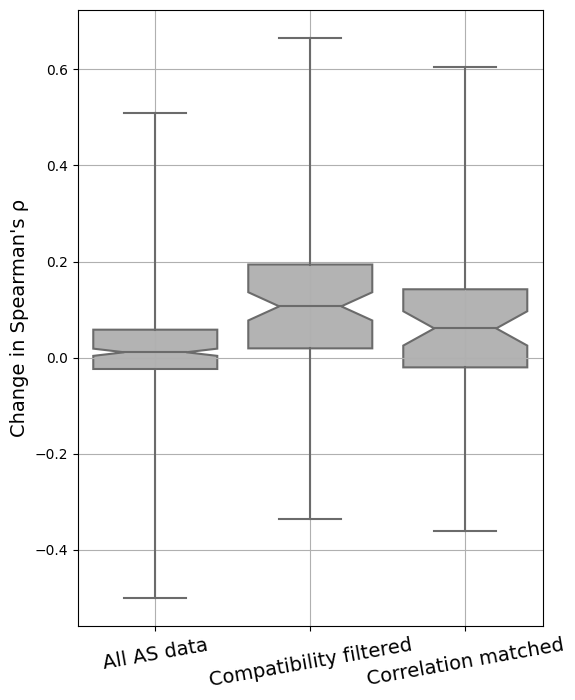

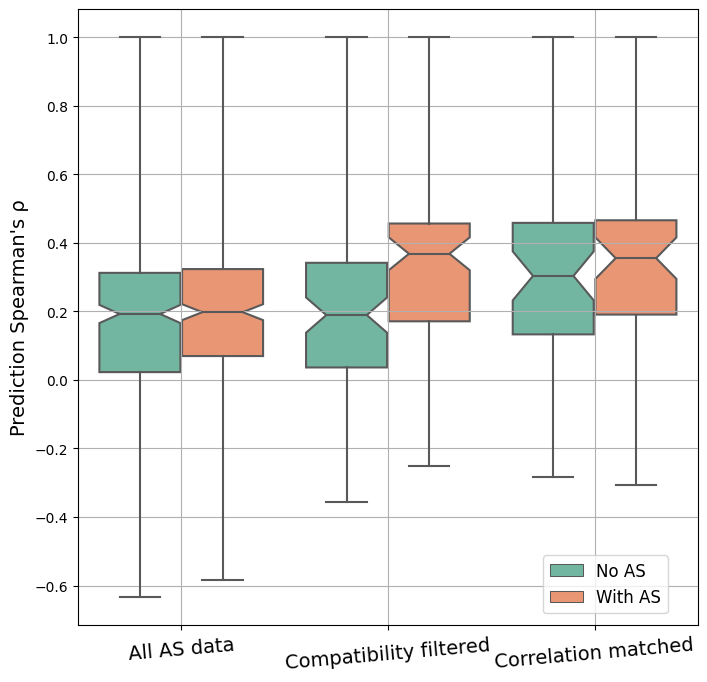

In [36]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform_avail[~model_perform_avail['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=10)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

long_data = vis_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                         var_name='Feature', value_name='spear')
fig, ax = plt.subplots(1,1,figsize=(8, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=long_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=5)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.75,0.02], fontsize=12)
ax.grid()
plt.show()

# Thresholded correlation matching

In the previous correlation filtering analysis, we match each DMS with AS data having the highest regularized DMS/AS correlation value ($ρ_r$). However, highest correlation does not necessarily means high consistency. Here we tried to threshold the correlation values as well. These results are related to __Fig S7__.

Here we:
1. Set a series of threshold values ($t$): 0, 0.25, 0.5
2. While doing correlation matching, we still pick the AS data with highest regularized DMS/AS correlation ($ρ_r$)
3. A further filtering was done and data were kept only when: $ρ_r > t$
4. The predictors are trained and evaluated as previously done

In [51]:
# Pick AS data with highest regularized correlation for DMS study, constrainting that 
# the correlation is larger than the threshold.
thcorr_ids = []
for threshold in [0, 0.25, 0.5]:
    for index, df in data_info.groupby('dms_id', as_index=False):
        df = df[df['regularized_correlation'] > threshold]
        df = df.sort_values(['regularized_correlation', 'n_ala', 'Ascan_id'])
        if len(df) > 0:
            row = df.iloc[-1][['dms_id', 'Ascan_id']]  # Pick data with largest regularized correlation.
            row['threshold'] = threshold
            thcorr_ids.append(row)
thcorr_ids = pd.DataFrame(thcorr_ids)

for threshold, id_data in thcorr_ids.groupby('threshold'):
    # And matching DMS IDs.
    thcorr_as = pd.merge(norm_as, id_data, on='Ascan_id', how='left')
    dms_thcorr_as = pd.merge(norm_dms, thcorr_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                           on=['dms_id', 'u_pos'], how='left')

    # Identifier for each DMS+AS combined dataset.
    dms_thcorr_as['dmsa_id'] = dms_thcorr_as['dms_id'] + '@' + dms_thcorr_as['Ascan_id'].astype(str)
    dms_thcorr_as['Ascan_score_avail'] = ~dms_thcorr_as['AS_score'].isna()
    dms_thcorr_as, encoded_col = preproc_demask_dmsas_data(dms_thcorr_as)

    model_linear_predictor_lopo(dms_thcorr_as, 
                                f"../result/prediction/alternative_models/thresholded/{threshold}/", 
                                encoded_col)

In [52]:
file_dir = {'All AS data': '../result/prediction/linear_as/all_as/',
            'Compatibility filtered': '../result/prediction/linear_as/compatible_as/',
            'Correlation matched': '../result/prediction/linear_as/correlate_as/',
            'Correlation matched (ρᵣ>0)': '../result/prediction/alternative_models/thresholded/0.0/',
            'Correlation matched (ρᵣ>0.25)': '../result/prediction/alternative_models/thresholded/0.25/',
            'Correlation matched (ρᵣ>0.5)': '../result/prediction/alternative_models/thresholded/0.5/'}
target_proteins = norm_dms['uniprot_id'].unique()

# Read prediction results.
thcorr_mut_prediction = dict()
for model in file_dir.keys():
    pred_merge = read_lopo_prediction_result(file_dir[model], target_proteins)
    thcorr_mut_prediction[model] = pred_merge
    
# Evaluate performance with Spearman's ρ on each DMS/AS pair.
thcorr_model_perform = []
for model in thcorr_mut_prediction.keys():
    perf_with_as = ana.subgroup_spearmanr(thcorr_mut_prediction[model], 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(thcorr_mut_prediction[model], 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    thcorr_model_perform.append(perf_merge)
thcorr_model_perform = pd.concat(thcorr_model_perform)

# Post process.
thcorr_model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
thcorr_model_perform['diff_spear'] = thcorr_model_perform['With AS'] - thcorr_model_perform['No AS']
thcorr_model_perform = pd.merge(thcorr_model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

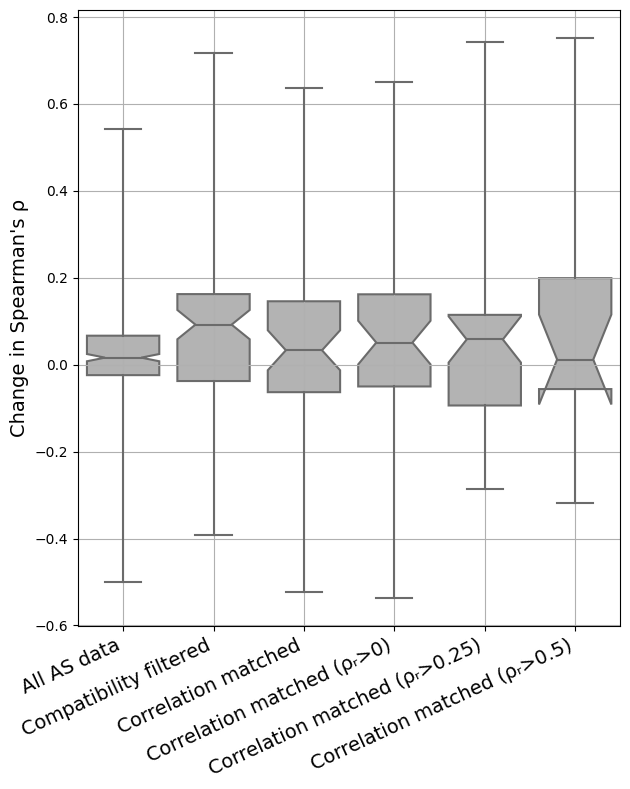

In [53]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = thcorr_model_perform[~thcorr_model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(7, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=25, ha='right')
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

# Evaluating with averaged DMS/AS scores

Some DMS and AS data are quite similar to each other, that they may only differs by replicates or strength of selection. Here we tried average those highly-similar-result, to investigate if these pseudo-replicates may affect model performance. This result is realted to __Fig S8__.

To do this:
1. We grouped all DMS or AS data statisfys the following criteria simultaneously:
    * Published from the same paper
    * Targeting the same protein region
    * Measured by the same type of assays (Supplementary Table 1)
2. The orignial prediction results on these pseudo-duplicated datasets are averaged
3. The final performance on averaged-DMS/AS pairs are visualized.

In [6]:
dms_group = [['urn:mavedb:00000001-a-2', 'urn:mavedb:00000001-a-3'], # Sequence method, UBE2I
             ['urn:mavedb:00000005-a-5', 'urn:mavedb:00000005-a-6'], # Molecule addition, CBS
             ['urn:mavedb:00000012-a-2', 'urn:mavedb:00000012-a-3', 
              'urn:mavedb:00000012-a-4', 'urn:mavedb:00000012-a-5', 'urn:mavedb:00000012-a-6'], # Selection time, replicates, Gal4
             ['urn:mavedb:00000038-a-1', 'urn:mavedb:00000038-b-1', 'urn:mavedb:00000038-b-2'], # Molecule addition (concentration), Ub
             ['urn:mavedb:00000047-a-1', 'urn:mavedb:00000047-b-1'],  # Ways to measure expression level, CCR5
             ['urn:mavedb:00000048-a-1', 'urn:mavedb:00000048-c-1'],  # Ways to measure expression level, CXCR4
             ['urn:mavedb:00000052-a-1', 'urn:mavedb:00000052-b-1'],  # Molecule concentration, GCN4
             ['urn:mavedb:00000057-a-1', 'urn:mavedb:00000057-b-1', 'urn:mavedb:00000057-c-1'], # Molecule addition, RAS 
             ['urn:mavedb:00000061-a-1', 'urn:mavedb:00000061-b-1', 'urn:mavedb:00000061-c-1',
              'urn:mavedb:00000061-d-1', 'urn:mavedb:00000061-e-1', 'urn:mavedb:00000061-f-1', 
              'urn:mavedb:00000061-g-1', 'urn:mavedb:00000061-h-1', 'urn:mavedb:00000061-i-1'], # Selection time, RAF1
             ['urn:mavedb:00000068-b-1', 'urn:mavedb:00000068-c-1']] # Molecule addition, TP53

as_group = [['ace2_han_20', 'ace2_han_40_plasmid', 'ace2_han_60_plasmid'],  # Concentration, time
            ['calm1_met_rate', 'calm1_met_rate_ca'],  # Molecule
            ['calm1_met_rate_cacl2_h6', 'calm1_met_rate_egta_h6'],  # Molecule
            ['calm1_met_rate_cacl2_h7', 'calm1_met_rate_egta_h7'],  # Molecule
            ['cbs_kopecka_actala0', 'cbs_kopecka_actala5', 'cbs_kopecka_baralan', 'cbs_kopecka_baralay'],  # Molecule
            ['cbs_kopecka_tetraala0', 'cbs_kopecka_tetraala5'],  # Molecule
            ['cbs_kopecka_actbeta0', 'cbs_kopecka_actbeta1', 'cbs_kopecka_actgly0', 'cbs_kopecka_actgly7',
             'cbs_kopecka_acttau0', 'cbs_kopecka_acttau5', 'cbs_kopecka_barbetan', 'cbs_kopecka_barbetay',
             'cbs_kopecka_barglyn', 'cbs_kopecka_barglyy', 'cbs_kopecka_tetrabeta0', 'cbs_kopecka_tetrabeta1',
             'cbs_kopecka_tetragly0', 'cbs_kopecka_tetragly7', 'cbs_kopecka_tetratau0', 'cbs_kopecka_tetratau5'],  # Molecule
            ['cbs_18_met', 'cbs_18_no', 'cbs_37_met', 'cbs_37_no'],  # Molecule, temprature
            ['cbs_singh_0', 'cbs_singh_05', 'cbs_singh_1', 'cbs_singh_2', 'cbs_singh_4', 'cbs_singh_400'],  # Concentration
            ['ccr5_dragic_ada', 'ccr5_dragic_dh123', 'ccr5_dragic_jrfl'],  # Molecule
            ['ccr5_dragic_mip1a', 'ccr5_dragic_mip1b', 'ccr5_dragic_pantes'],  # Diff. readouts
            ['ccr5_dragic_jrfl_bind', 'ccr5_dragic_jrfl_bindenhan'],  # Expression
            ['ccr5_rabut_ada', 'ccr5_rabut_dh123', 'ccr5_rabut_gun1', 'ccr5_rabut_jrfl'],  # Diff. readouts
            ['ccr5_blanpain_239', 'ccr5_blanpain_jrfl'],  # Diff. readouts
            ['ccr5_nave_227r', 'ccr5_nave_2d7'],  # Diff. readouts
            ['ccr5_nave_mip1a', 'ccr5_nave_rantes'],  # Diff. readouts
            ['ccr5_zhang_roab12', 'ccr5_zhang_roab13', 'ccr5_zhang_roab14', 'ccr5_zhang_roab18'],  # Diff. readouts
            ['ccr5_tan_jrfl', 'ccr5_tan_sf162'],  # Diff. readouts
            ['cxcr4_chabot_896', 'cxcr4_chabot_bh10', 'cxcr4_chabot_lav', 'cxcr4_chabot_sf2'],  # Diff. readouts
            ['cxcr4_chabot_infhxb2', 'cxcr4_chabot_infnl43'],  # Diff. readouts
            ['cxcr4_chabot_cys_12g5', 'cxcr4_chabot_cys_4g10'],  # Diff. readouts
            ['cxcr4_lin_exp44717', 'cxcr4_lin_exp6h8'],  # Diff. readouts
            ['cxcr4_lin_rodb-cd4', 'cxcr4_lin_rodb-pc', 'cxcr4_lin_vcp-cd4', 'cxcr4_lin_vcp-pc'],  # Diff. readouts
            ['cxcr4_tian_896ecl2', 'cxcr4_tian_iiibecl2'],  # Diff. readouts
            ['gcn4_arg3', 'gcn4_arg5', 'gcn4_his4'],  # Diff. readout
            ['mpl_10htpo', 'mpl_1pf'],  # Molecule,
            ['raf1_kd_lowionic', 'raf1_kd_physicoion', 'raf1_transact_erk1G12V'],  # Condition, readouts
            ['ras_yoshi_gdpdis', 'ras_yoshi_gtpdis'],  # Diff. readout
            ['sumo1_galtat', 'sumo1_tat3'],  # Promoter
            ['tp53_chen_aspp2', 'tp53_chen_iaspp'],  # Diff. readout
            ['ube2i_ikba', 'ube2i_p53', 'ube2i_rangap1'],  # Diff. readout
            ['ube2i_luciferase_back1', 'ube2i_luciferase_back2', 'ube2i_luciferase_back4'],  # Concentration
            ['ube2i_luciferase_front2', 'ube2i_luciferase_front4'],  # Concentration
            ['ub_free', 'ub_poly'],  # Diff. readout
            ['aicda_gajula_deamine', 'aicda_gajula_growth']]  # Diff. readout

In [7]:
# These codes are identical as Part 2.

file_dir = {'All AS data': '../result/prediction/linear_as/all_as/',
            'Compatibility filtered': '../result/prediction/linear_as/compatible_as/',
            'Correlation matched': '../result/prediction/linear_as/correlate_as/'}
target_proteins = norm_dms['uniprot_id'].unique()

# Read prediction results.
mut_prediction = dict()
for model in file_dir.keys():
    pred_merge = read_lopo_prediction_result(file_dir[model], target_proteins)
    mut_prediction[model] = pred_merge

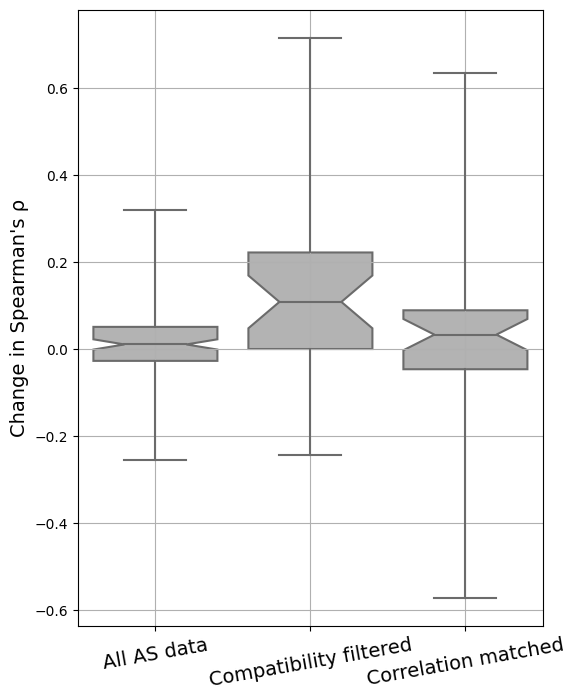

In [8]:
mean_model_perform = []
for model in mut_prediction.keys():
    # Add related info.
    work_data = pd.merge(mut_prediction[model], data_info[['dmsa_id', 'dms_id', 'uniprot_id', 'Ascan_id']].drop_duplicates(), 
                         on='dmsa_id', how='left', validate='m:1')
    work_data = pd.merge(work_data, dms_all_as[['dmsa_id', 'position', 'u_pos']].drop_duplicates(), 
                         on=['dmsa_id', 'position'], how='left', validate='m:1')
    work_data = work_data[work_data['Ascan_id'].notna()]
    
    # Average on pseudo-replicated DMS.
    merged_data = []
    disgard_id = []
    for merge_dms_ids in dms_group:
        new_dms = work_data[work_data['dms_id'].isin(merge_dms_ids)].copy()
        new_dms = new_dms.drop(columns=['dms_id', 'position'])
        new_dms = new_dms.groupby(['Ascan_id', 'uniprot_id', 'u_pos', 'aa2'], as_index=False).mean(numeric_only=True)
        new_dms['dms_id'] = merge_dms_ids[0]  # The first ID is inherited for the new DMS ID.
        new_dms['dmsa_id'] = new_dms['dms_id'] + '@' + new_dms['Ascan_id']
        new_dms['position'] = new_dms['u_pos']
        disgard_id.extend(merge_dms_ids)
        merged_data.append(new_dms)
    work_data = pd.concat([work_data[~work_data['dms_id'].isin(disgard_id)]] + merged_data, ignore_index=True)

    # Average on pseudo-replicated AS.
    merged_data = []
    disgard_id = []
    for merge_as_ids in as_group:
        new_dms = work_data[work_data['Ascan_id'].isin(merge_as_ids)].copy()
        new_dms = new_dms.drop(columns=['Ascan_id', 'position'])
        new_dms = new_dms.groupby(['dms_id', 'uniprot_id', 'u_pos', 'aa2'], as_index=False).mean(numeric_only=True)
        new_dms['Ascan_id'] = merge_as_ids[0]  # The first ID is inherited for the new AS ID.
        new_dms['dmsa_id'] = new_dms['dms_id'] + '@' + new_dms['Ascan_id']
        new_dms['position'] = new_dms['u_pos']
        disgard_id.extend(merge_as_ids)
        merged_data.append(new_dms)
    work_data = pd.concat([work_data[~work_data['Ascan_id'].isin(disgard_id)]] + merged_data, ignore_index=True)
    
    # Remove data with only one residue available.
    upos_count = work_data.groupby('dmsa_id')['u_pos'].nunique()
    rm_data = upos_count[upos_count <= 1].index
    work_data = work_data.query("dmsa_id not in @rm_data")
    
    # Evaluate performance
    perf_with_as = ana.subgroup_spearmanr(work_data, 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(work_data, 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    mean_model_perform.append(perf_merge)
mean_model_perform = pd.concat(mean_model_perform)

# Post process.
mean_model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
mean_model_perform['diff_spear'] = mean_model_perform['With AS'] - mean_model_perform['No AS']

# Remove data that no or only one one residue has (filtered) AS score.
vis_data = mean_model_perform.copy()
fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=10)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

# Boosting predictor

To deal with the sparsity of AS data, we tried to build the variant impact predictor in a boosting way:

To do this:
1. A first linear regression predictor was trained with all training DMS data using the three DeMaSk features __without AS data__, which is the same as the main control predictor.
2. Then the prediction error of is calculated by subtracting the predicted scores from DMS scores for training data.
3. After that, a second linear regression predictor was trained to __predict the error__, which uses the DeMaSk features as well as __AS data of high assay compatibility__.
4. The final prediction result is the sum of the outputs from these two predictors.

## Training & testing

In [26]:
# This part is the same as the data preparation for high compatibility filtering (P2-2.2.1)
# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

dms_comp_as = pd.merge(norm_dms, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')
dms_comp_as['dmsa_id'] = dms_comp_as['dms_id'] + '@' + dms_comp_as['Ascan_id'].astype(str)
dms_comp_as['Ascan_score_avail'] = ~dms_comp_as['AS_score'].isna()
dms_comp_as, encoded_col = preproc_demask_dmsas_data(dms_comp_as)

In [27]:
def first_step_modelling(train_data_ori, test_data_ori, first_features):
    """First step of boosting prediction which uses no AS feature.
    """
    train_data = train_data_ori.copy()
    test_data = test_data_ori.copy()
    
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[first_features], train_data['score'], train_data['weight'])
    
    train_data['first_pred'] = predictor.predict(train_data[first_features])
    train_data['diff_pred'] = train_data['score'] - train_data['first_pred']
    
    test_data['first_pred'] = predictor.predict(test_data[first_features])
    test_data['diff_pred'] = test_data['score'] - test_data['first_pred']
    return train_data, test_data


def second_step_modelling(train_data_ori, test_data_ori, second_features):
    """Second step of boosting prediction which uses AS feature.
    """
    train_data = train_data_ori.copy()
    test_data = test_data_ori.copy()
    
    train_data = train_data[train_data['Ascan_score_avail']].copy()  # Limit to data with AS scores.
    train_data = train.add_training_weight(train_data.drop(columns='weight'))  # Reset weight.
    
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[second_features], train_data['diff_pred'], train_data['weight'])
    
    train_data['second_pred'] = predictor.predict(train_data[second_features])
    train_data['final_pred'] = train_data['first_pred'] + train_data['second_pred']
    
    test_data['second_pred'] = predictor.predict(test_data[second_features])
    test_data['final_pred'] = test_data['first_pred'] + test_data['second_pred']
    return train_data, test_data

In [11]:
# Modelling.
first_features = DEMASK_FEATURES.copy()
second_features = DEMASK_FEATURES + encoded_col + ['AS_score']

# Leave-one-protein-out cross-validation.
for unip in dms_comp_as['uniprot_id'].unique():  
    train_data = dms_comp_as.query("uniprot_id != @unip").copy()
    test_data = dms_comp_as.query("uniprot_id == @unip").copy()
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
            
    # First step: no AS feature.
    train_data, test_data = first_step_modelling(train_data, test_data, first_features)
    # Second step: with AS feature.
    train_data, test_data = second_step_modelling(train_data, test_data, second_features)
    
    # Saving.
    output_header = f"../result/prediction/alternative_models/boosting/{unip}_"
    test_data[["dmsa_id", "position", "aa2", "score", "final_pred", "first_pred"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

The boosting result is evaluated the same as previously mentioned and compared with the previous _compatibility filtered_ result which is noted here as the _main result_, creating __Figure S12__.

In [29]:
# Data reading and evaluation.
root = '../result/prediction/alternative_models/boosting/'
boosting_result = pd.concat([pd.read_csv(f"{root}{unip}_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
boost_perf = ana.subgroup_spearmanr(boosting_result, 'dmsa_id', 'score', 'final_pred')

In [30]:
# Prepare data for visualisation.
# Get (one-step) compatibility filtering result for comparison.
root = '../result/prediction/linear_as/compatible_as/'
comp_filt_result = pd.concat([pd.read_csv(f"{root}{unip}_with_as_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
comp_filt_perf = ana.subgroup_spearmanr(comp_filt_result, 'dmsa_id', 'score', 'pred_score')

# Merge performance results.
bench_data = pd.merge(boost_perf, comp_filt_perf, left_index=True, right_index=True, validate='1:1', 
                      how='outer', suffixes=['_boost', '_onestep'])
bench_data = bench_data[bench_data.index.str[-4:] != '@nan']  # Remove data without available (filtered) AS score.
bench_data['Protein name'] = bench_data.index.map(data_info.groupby('dmsa_id').protein_name.first())
bench_data = bench_data.rename(columns={'size_boost': 'Size'})  # size_boost and size_onestep are the same.

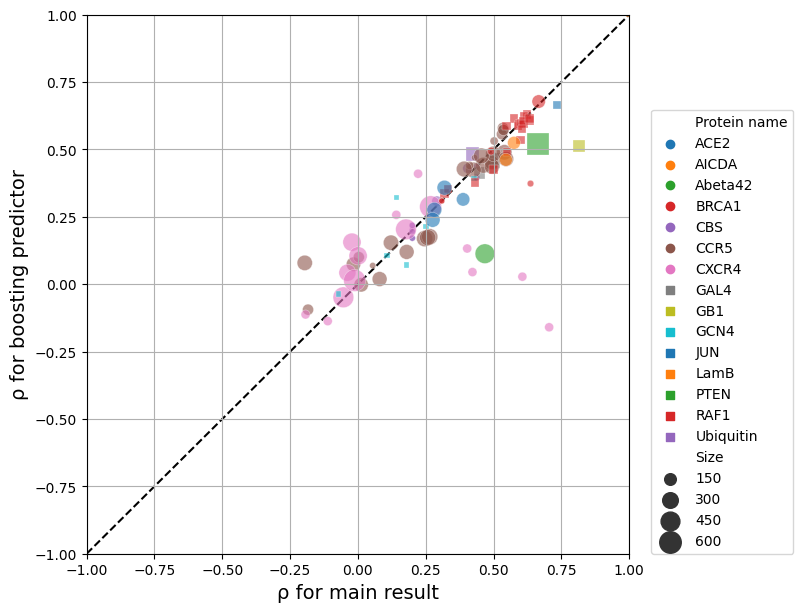

In [31]:
# Set makers.
order = np.sort(bench_data['Protein name'].unique())
half = int(len(order)/2)
markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.patch.set_facecolor('w')
g = sns.scatterplot(data=bench_data, x='rho_onestep', y='rho_boost', size='Size', hue='Protein name', 
                    hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                    palette="tab10", markers=markers)
ax.plot([-1,1],[-1,1], '--', c='k', zorder=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ρ for main result', fontsize=14)
ax.set_ylabel('ρ for boosting predictor', fontsize=14)
ax.legend(loc=(1.04, 0))
ax.grid(zorder=0)
plt.show()

# Replace AS with DMS-Ala for training

Another potential approach to overcome the sparsity of AS data is by replacing the AS feature with the DMS scores on alanine substitutions (DMS-Ala) for the __training process__. Compared to AS data, DMS-Ala scores are available for most DMS variants. They also show reasonable correlation with the AS scores.

To do this:
1. For the __training data__, we take DMS-Ala scores for all DMS data we collected.
2. The DMS-Ala scores are merged with the original DMS data, replacing the real AS data.
3. DMS-Ala scores are imputed, encoded and included in model training just as what we did with AS data previously.
4. __But the testing data remain using AS scores for prediction.__

## Training & testing

In [32]:
# Data preparation

# Data for training, with DMS score of alanine substitution (DMS-Ala) score replacing AS score.
sim_scan = norm_dms.query("aa2 == 'A'")[['dms_id', 'position', 'score']]
sim_scan.rename(columns={'score': 'AS_score'}, inplace=True)  # Easier to interpret, should actually be DMS-Ala.
dms_simscan = pd.merge(norm_dms, sim_scan, on=['dms_id', 'position'], how='left', validate='m:1')
dms_simscan, encoded_col = preproc_demask_dmsas_data(dms_simscan)

# Data for testing, with AS scores kept.
# This part is the same as the data preparation for training with all AS data (P2-2.1).
all_as = norm_as.copy()
dms_all_as = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()
dms_all_as = preproc.impute_missing_value(dms_all_as, None, ['AS_score'])
dms_all_as, encoded_col = preproc.encode_categorical_feature(dms_all_as, ['aa1', 'aa2'], ['aa1', 'aa2'])
dms_all_as[encoded_col] = dms_all_as[encoded_col].mul(dms_all_as['AS_score'], axis='index')

In [16]:
# Modelling
for unip in dms_simscan['uniprot_id'].unique():
    train_data = dms_simscan.query("uniprot_id != @unip")  # Train data use DMS-Ala score.
    test_data = dms_all_as.query("uniprot_id == @unip").copy()  # Test data use AS score.
    train_data, test_data = train.refit_matrix_score(train_data, test_data)

    model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
    output_header = f"../result/prediction/alternative_models/dms-ala_train/{unip}_"
    estimator = LinearRegression(n_jobs=4)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['pred_score'] = predictor.predict(test_data[model_features])
    test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

The DMS-Ala training result is evaluated the same as previously mentioned and compared with the previous _compatibility filtered_ result which is noted here as the _main result_, creating __Figure S13__.

In [34]:
# Data reading and evaluation.
root = '../result/prediction/alternative_models/dms-ala_train/'
dmsala_result = pd.concat([pd.read_csv(f"{root}{unip}_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
dmsala_perf = ana.subgroup_spearmanr(dmsala_result, 'dmsa_id', 'score', 'pred_score')

In [35]:
# Prepare data for visualisation.
# Get compatibility filtering (AS trained) result for comparison.
root = '../result/prediction/linear_as/compatible_as/'
comp_filt_result = pd.concat([pd.read_csv(f"{root}{unip}_with_as_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
comp_filt_perf = ana.subgroup_spearmanr(comp_filt_result, 'dmsa_id', 'score', 'pred_score')

# Merge performance results.
# Merge on right, keeping highly comparable data only, for comparison purpose.
bench_data = pd.merge(dmsala_perf, comp_filt_perf, left_index=True, right_index=True, validate='1:1', 
                      how='right', suffixes=['_DMS-Alatrain', '_AStrain'])  
bench_data = bench_data[bench_data.index.str[-4:] != '@nan']  # Remove data without available (filtered) AS score.
bench_data['Protein name'] = bench_data.index.map(data_info.groupby('dmsa_id').protein_name.first())
bench_data = bench_data.rename(columns={'size_DMS-Alatrain': 'Size'})

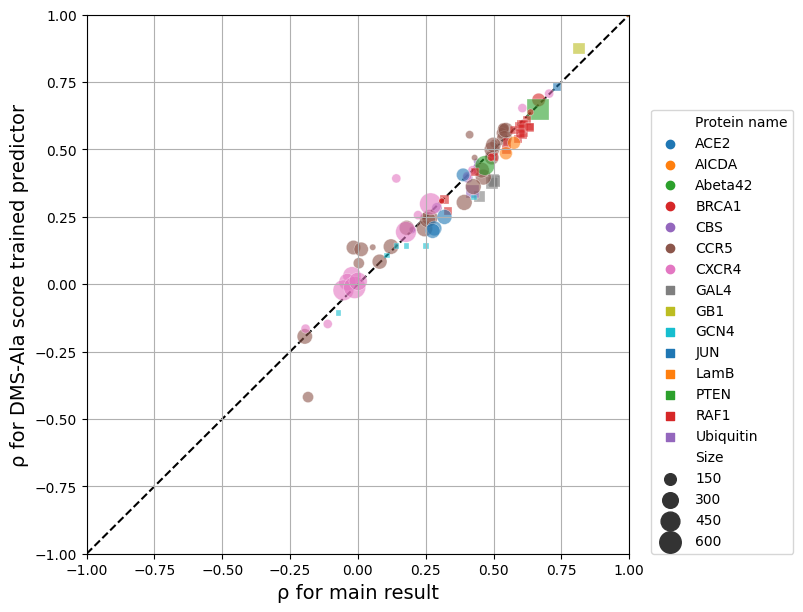

In [36]:
# Set makers.
order = np.sort(bench_data['Protein name'].unique())
half = int(len(order)/2)
markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.patch.set_facecolor('w')
g = sns.scatterplot(data=bench_data, x='rho_AStrain', y='rho_DMS-Alatrain', size='Size', hue='Protein name', 
                    hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                    palette="tab10", markers=markers)
ax.plot([-1,1],[-1,1], '--', c='k', zorder=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ρ for main result', fontsize=14)
ax.set_ylabel('ρ for DMS-Ala score trained predictor', fontsize=14)
ax.legend(loc=(1.04, 0))
ax.grid(zorder=0)
plt.show()

# Extra: replace AS with simulated scanning

Instead of using alanine scanning data, we want to investiagte how sacnning results on other substitution types may perform in our pipeline. Since low-throughput measurements of such variants were rare in our data, we used the DMS scores as a simulated single-residue scan for each amino acid.

To do this:
1. One amino acid is picked at a time for simulated scanning.
2. DMS scores for substitutions to this amino acid were picked up as simulated scanning scores.
3. The simulated scanning scores were merged with the __original DMS__ data and were imputed and encoded as the AS data.
4. The prediction model is built similar as previously mentioned.
5. During the evaluation process, the DMS scores of the chosen variant amino acid type were __excluded__ since they have already been used as feature values.
6. The process is iterated over all amino acids.

## Training & testing

In [21]:
def model_simulated_scanning(dms_simscan, encoded_col, scan_aa2):
    """ Run leave-one-protein-out cross-validation on predicting with simulated scanning data.
    """
    # LOPO CV
    for unip in dms_simscan['uniprot_id'].unique():
        train_data = dms_simscan.query("uniprot_id != @unip")
        test_data_ori = dms_simscan.query("uniprot_id == @unip")
        train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)
        
        for model in ['with_simscan', 'no_simscan']:
            if model == 'with_simscan':
                model_features = DEMASK_FEATURES + encoded_col + ['scan_score']
                model = scan_aa2
            elif scan_aa2 == 'A':
                model_features = DEMASK_FEATURES.copy()
            # Result of no simulated scanning score have nothing to do with scan_aa2, so the rest will be skipped.
            else: 
                continue
            output_header = f"../result/prediction/alternative_models/simulated_scan/{unip}_{model}_"

            estimator = LinearRegression(n_jobs=4)
            predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
            test_data = test_data_ori.copy()
            test_data['pred_score'] = predictor.predict(test_data[model_features])
            test_data[["dms_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
    return

In [ ]:
# Modelling. This may take about 30min on MacBook Pro 15-inch 2018.
for scan_aa2 in 'ACDEFGHIKLMNPQRSTVWY':
    # Pick DMS score of given variant type as simulated low-throughput scanning scores.
    sim_scan = norm_dms.query("aa2 == @scan_aa2")[['dms_id', 'position', 'score']]
    sim_scan.rename(columns={'score': 'scan_score'}, inplace=True)
    dms_simscan = pd.merge(norm_dms, sim_scan, on=['dms_id', 'position'], how='left', validate='m:1')
    
    # Impute, encode & weight.
    dms_simscan = preproc.impute_missing_value(dms_simscan, None, ['scan_score'])
    dms_simscan, encoded_col = preproc.encode_categorical_feature(dms_simscan, ['aa1', 'aa2'], ['aa1', 'aa2'])
    dms_simscan[encoded_col] = dms_simscan[encoded_col].mul(dms_simscan['scan_score'], axis='index')
    dms_simscan = train.add_training_weight(dms_simscan)
    
    model_simulated_scanning(dms_simscan, encoded_col, scan_aa2)

## Evaluation

In [24]:
# Result reading and evaluation.
simscan_perf = []
root = '../result/prediction/alternative_models/simulated_scan/'
for scan_aa2 in 'ACDEFGHIKLMNPQRSTVWYZ':
    if scan_aa2 == 'Z':  # Place holder
        model = 'no_simscan'
    else:
        model = scan_aa2
        
    onesim_result = pd.concat([pd.read_csv(f"{root}{unip}_{model}_prediction.csv", index_col=0) 
                               for unip in norm_dms.uniprot_id.unique()])
    onesim_result = onesim_result.query("aa2 != @scan_aa2")  # Remove scores used as feature already.
    
    # Calculate prediction performance by Spearman's correlation on each DMS dataset.
    onesim_perf = ana.subgroup_spearmanr(onesim_result, 'dms_id', 'score', 'pred_score')
    onesim_perf = onesim_perf.reset_index().rename(columns={'index': 'dms_id'})
    onesim_perf['scan_aa2'] = scan_aa2
    simscan_perf.append(onesim_perf)
simscan_perf = pd.concat(simscan_perf)

The predicton correlation for using each simulated scanning result (or not), measured by Spearman's ρ on each DMS data.

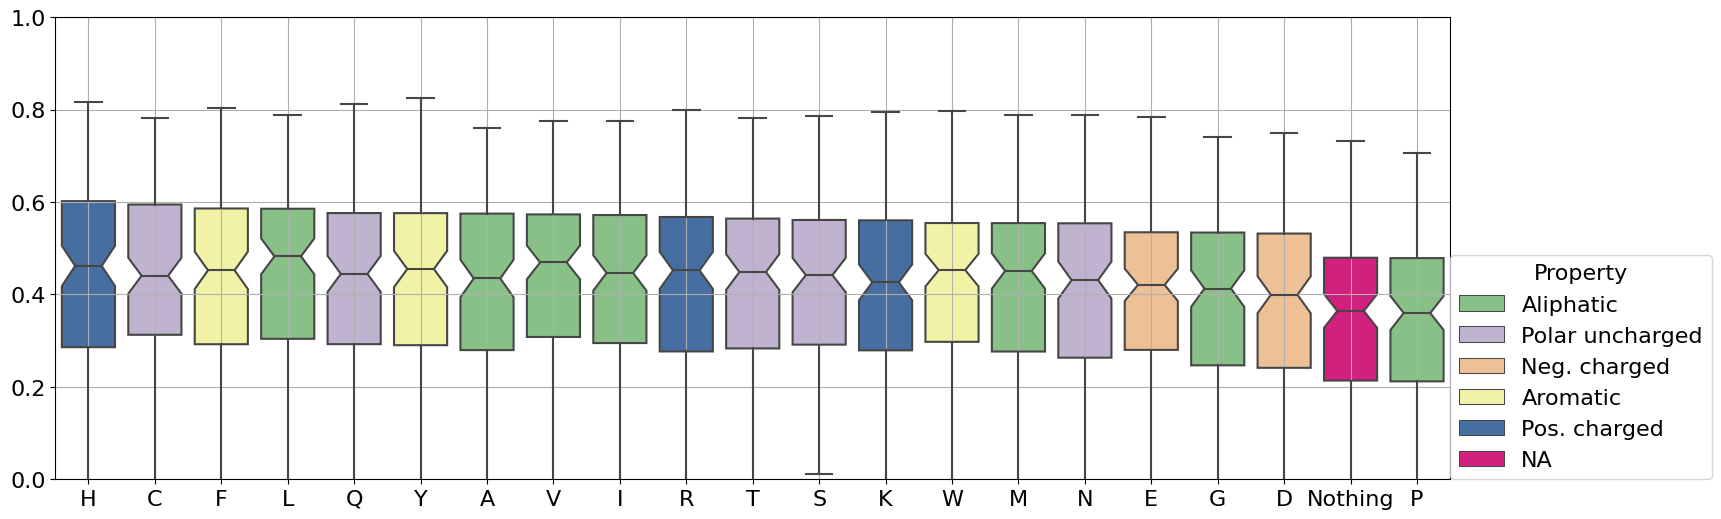

In [25]:
# Refine & add data info.
vis_data = simscan_perf.copy()
vis_data['scan_aa2'] = vis_data['scan_aa2'].replace({'Z': 'Nothing'})
vis_data['property'] = vis_data['scan_aa2'].map(AA_PROPERTY).fillna('NA')
    
fig, ax = plt.subplots(1,1,figsize=(18, 6))
fig.patch.set_facecolor('w')
order = list(vis_data.groupby('scan_aa2')[['rho']].quantile(0.75).sort_values('rho', ascending=False).index)
sns.boxplot(x='scan_aa2', y='rho', data=vis_data, hue='property', notch=True, dodge=False,
            whis=np.inf, ax=ax, order=order, palette='Accent')

# Aesthetics.
ax.legend(loc=[1,0], fontsize=16).set_title('Property',prop={'size':16})
ax.set_ylim([0,1])
ax.set_yticks([0.,0.2,0.4,0.6,0.8,1.])
ax.set_yticklabels([0.,0.2,0.4,0.6,0.8,1.], fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')
plt.grid()

plt.show()